In [1]:
from __future__ import print_function, division, absolute_import

import gc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy as np


In [2]:
from sklearn.datasets import make_moons
x_train, y_train = make_moons(n_samples = 5000, noise = 0.10)
x_test, y_test = make_moons(n_samples = 2000, noise = 0.10)
y_test = y_test.astype(np.float32)
y_train = y_train.astype(np.float32)

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.autograd import Variable

np.random.seed(0)
torch.manual_seed(0)
#torch.cuda.manual_seed(0)

In [4]:
def log_gaussian_prob(x, mu, sigma):
    element_wise_log_prob = -0.5*torch.Tensor([np.log(2*np.pi)]).to(mu.device) - torch.log(sigma) - 0.5*(x-mu)**2 / sigma**2
    return element_wise_log_prob.sum()

class GaussianLinear(nn.Module):
    def __init__(self, in_dim, out_dim, stddev_prior = 1.0):
        super(GaussianLinear, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.stddev_prior = stddev_prior
        self.w_mu = nn.Parameter(torch.Tensor(out_dim, in_dim))
        self.w_rho = nn.Parameter(torch.Tensor(out_dim, in_dim))
        self.b_mu = nn.Parameter(torch.Tensor(out_dim))
        self.b_rho = nn.Parameter(torch.Tensor(out_dim))
        self.q_w = 0.
        self.p_w = 0.
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.w_mu, a=np.sqrt(5))
        nn.init.kaiming_uniform_(self.w_rho, a=np.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.w_mu)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.b_mu, -bound, bound)
        nn.init.uniform_(self.b_rho, -bound, bound)

    def forward(self, x, test=False):
        if test:
            w = self.w_mu
            b = self.b_mu
        else:
            device = self.w_mu.device
            w_stddev = 1e-1*F.softplus(self.w_rho)
            b_stddev = 1e-1*F.softplus(self.b_rho)
            w = self.w_mu + w_stddev * torch.Tensor(self.out_dim, self.in_dim).to(device).normal_(0,1.0)
            b = self.b_mu + b_stddev * torch.Tensor(self.out_dim).to(device).normal_(0,1.0)
            self.q_w = log_gaussian_prob(w, self.w_mu, w_stddev)
            self.p_w = log_gaussian_prob(w, torch.zeros_like(self.w_mu, device=device), self.stddev_prior*torch.ones_like(w_stddev, device=device))
            self.q_w += log_gaussian_prob(b, self.b_mu, b_stddev)
            self.p_w += log_gaussian_prob(b, torch.zeros_like(self.b_mu, device=device), self.stddev_prior*torch.ones_like(b_stddev, device=device))
        #return x@w+b
        return F.linear(x, w, b)

    def get_pw(self):
        return self.p_w

    def get_qw(self):
        return self.q_w

class ModelBNN(nn.Module):
    def __init__(self, L, layers, stddev_prior = 1.0):
        super(ModelBNN, self).__init__()
        self.stddev_prior = stddev_prior
        
        self.layers = [L]+layers+[1]
        self.linear = nn.ModuleList([])
        for ii in range(1, len(self.layers)):
            self.linear.append(GaussianLinear(self.layers[ii-1], self.layers[ii], stddev_prior))

        self.relu = nn.ReLU()

    def forward(self, x, test=False):
        y = x
        for ii in range(1, len(self.layers)):
            y = self.linear[ii-1](y, test)
            if ii != len(self.layers)-1:
                y = self.relu(y)
        return y

    def forward_samples(self, x, y, nb_samples=1):
        total_qw, total_pw, total_log_likelihood = 0., 0., 0.
        for _ in range(nb_samples):
            output = self.forward(x)
            total_qw += self.get_qw()
            total_pw += self.get_pw()
            total_log_likelihood += log_gaussian_prob(y, output, 0.05*torch.ones_like(y))
        return total_qw / nb_samples, total_pw / nb_samples, total_log_likelihood / nb_samples

    def get_pw(self):
        return sum([self.linear[ii-1].p_w for ii in range(1, len(self.layers))])

    def get_qw(self):
        return sum([self.linear[ii-1].q_w for ii in range(1, len(self.layers))])


In [5]:
Nepochs = 30
layers = [50, 10]
L = 2
batch_size = 20

In [6]:
def mse_fn(model, x, y):
    return torch.pow(model(x)-y, 2).sum(1).mean(0)

def fit_model(layers, Nepochs, x_train, y_train):
    N = x_train.shape[0]
    L = x_train.shape[1]
    
    model = ModelBNN(L = L, layers = layers, stddev_prior = 1.0)
    #model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr = 1e-2)
    
    for i in range(Nepochs):
        old_batch = 0
        loss_ = 0
        nll_ = 0
        kl_ = 0
        mse_ = 0
        Nbatches = int(np.ceil(N/batch_size))
        pall = np.random.permutation(N)
        for batch in range(Nbatches):
            #p = np.random.choice(N, batch_size)
            p = pall[batch*batch_size : (batch+1)*batch_size]
            _x = x_train[p, :].astype(np.float32)
            _y = y_train[p, np.newaxis].astype(np.float32)
            
            x = torch.as_tensor(_x) #.cuda()
            y = torch.as_tensor(_y) #.cuda()
            
            qw, pw, llh = model.forward_samples(x, y)
            kl_loss = (qw-pw)/(float(N)/float(batch_size))
            nll_loss = -llh
            loss_total = nll_loss + kl_loss
            
            optimizer.zero_grad()
            loss_total.backward()
            optimizer.step()

            mse = mse_fn(model, x, y)
            
            loss_ += loss_total.item()
            nll_ += nll_loss.item()
            kl_ += kl_loss.item()
            mse_ += mse.item()
            print("Epoch {:>3d}, {:^12s}: loss = {:>5.4f}, nll = {:>5.4f}, kl = {:>5.4f}, mse = {:>5.4f}".format(i,
                                        "{:>3d}/{:>3d}".format(batch+1, Nbatches),
                                        (loss_)/float(batch+1), nll_/float(batch+1), kl_/float(batch+1),
                                        mse_/float(batch+1)
                                        ),
                  
                  end = '\r')


        loss_ /= float(Nbatches)
        nll_ /= float(Nbatches)
        kl_ /= float(Nbatches)
        mse_ /= float(Nbatches)
        print("Epoch {:>3d}, {:^12s}: loss = {:>5.4f}, nll = {:>5.4f}, kl = {:>5.4f}, mse = {:>5.4f}".format(i,
                                        "",
                                        (loss_), nll_, kl_,
                                        mse_
                                        ),
                  
                  end = '\n')            
    return model

In [7]:
model = fit_model(layers, Nepochs, x_train, y_train)

Epoch   0,             : loss = 320.0831, nll = 314.4385, kl = 5.6447, mse = 0.087042
Epoch   1,             : loss = 68.0809, nll = 62.6481, kl = 5.4328, mse = 0.026088
Epoch   2,             : loss = 27.8943, nll = 22.5281, kl = 5.3662, mse = 0.0171
Epoch   3,             : loss = 15.3858, nll = 10.0804, kl = 5.3055, mse = 0.01217
Epoch   4,             : loss = 6.4404, nll = 1.1879, kl = 5.2526, mse = 0.010355
Epoch   5,             : loss = 5.1354, nll = -0.0567, kl = 5.1921, mse = 0.00969
Epoch   6,             : loss = -0.1773, nll = -5.3425, kl = 5.1653, mse = 0.0087
Epoch   7,             : loss = 0.1462, nll = -4.9850, kl = 5.1311, mse = 0.008752
Epoch   8,             : loss = -7.4796, nll = -12.5641, kl = 5.0845, mse = 0.00680
Epoch   9,             : loss = -6.8985, nll = -11.9296, kl = 5.0311, mse = 0.00695
Epoch  10,             : loss = -8.2265, nll = -13.2371, kl = 5.0106, mse = 0.00640
Epoch  11,             : loss = -11.6354, nll = -16.6063, kl = 4.9710, mse = 0.0059


In [8]:
def getMeanStd(model, x, Npred = 50):
    # per-example predictions
    p = [None]*Npred
    x_ = torch.as_tensor(x.astype(np.float32)) #.cuda()
    for k in range(Npred):
        p[k] = model(x_)
        p[k] = p[k].detach().numpy()[np.newaxis,...,0]
    p = np.concatenate(p, axis = 0)
    return np.mean(p, axis = 0), np.std(p, axis = 0)

In [9]:
def plot_contour(model, x, y, getFunction):
    # make countour
    mins = [np.min(x[:,0]), np.min(x[:,1])]
    maxs = [np.max(x[:,0]), np.max(x[:,1])]
    step = [(maxs[0] - mins[0])/50.0, (maxs[1] - mins[1])/50.0]
    bx, by = np.mgrid[mins[0]:(maxs[0]+0.5*step[0]):step[0], mins[1]:(maxs[1]+0.5*step[0]):step[1]]
    inputs = np.vstack([bx.flatten(), by.flatten()]).T
    inputs = inputs.astype(np.float32)

    pred_m, pred_s = getFunction(model, inputs, Npred = 50)
    pred_m_2d = pred_m.reshape( (-1, bx.shape[1]) )
    pred_s_2d = pred_s.reshape( (-1, bx.shape[1]) )

    # if one wants to smoothen the results
    #for data in [pred_m_2d, pred_s_2d]:
    #    data = gaussian_filter(data, 0.1)

    fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (10, 8))
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    contour_s = ax[0].contourf(bx, by, pred_s_2d, cmap = cmap)
    cbar_s = plt.colorbar(contour_s, ax = ax[0])
    cbar_s.ax.set_ylabel('Unc.')
    contour_m = ax[1].contourf(bx, by, pred_m_2d, cmap = cmap)
    #contour_m.set_clim(0,1)
    cbar_m = plt.colorbar(contour_m, ax = ax[1])
    cbar_m.ax.set_ylabel('Mean')
    for a in [ax[0], ax[1]]:
        a.scatter(x[y == 1,0], x[y == 1,1], color = 'r', marker = 's', s = 5, label = 'y = 1')
        a.scatter(x[y == 0,0], x[y == 0,1], color = 'b', marker = 's', s = 5, label = 'y = 0')
        a.set(xlabel = 'A', ylabel = 'B', title = '')
        a.set_xlim([mins[0], maxs[0]])
        a.set_ylim([mins[1], maxs[1]])
        a.legend(frameon = True)
    ax[0].set_xlabel('')
    fig.subplots_adjust(hspace = 0)
    fig.tight_layout()
    plt.show()

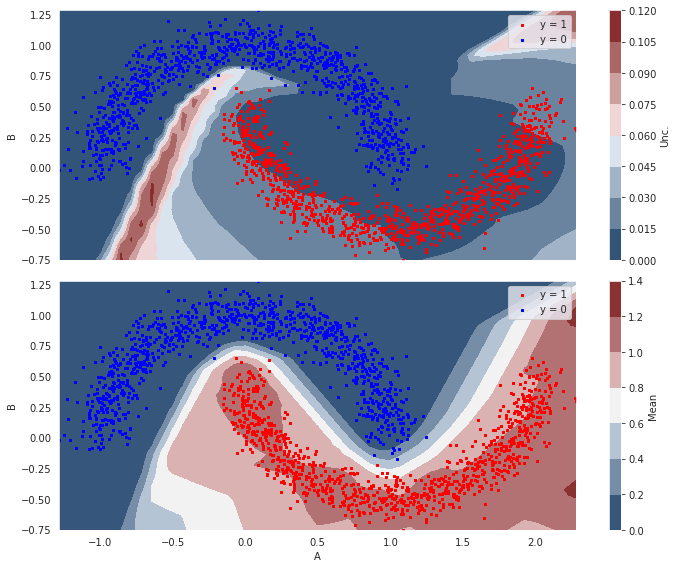

In [10]:
plot_contour(model, x_test, y_test, getFunction = getMeanStd)